# Test the projection convergence of our basis constructed using OMP

In [1]:
import numpy as np
import scipy as sp
import importlib
import seaborn as sns
import matplotlib.pyplot as plt
import pdb

import sys
sys.path.append("../../")
import pyApproxTools as pat
importlib.reload(pat)

%matplotlib inline

### Collective OMP algorithm

We construct a measurement basis $W_m$ based on a given approximation basis $V_n$. Our ambient space $V$ is $H_0^1([0,1])$. Here $V_n$ is the sinusoids, normalised in $H_0^1([0,1])$, so $V_n = \mathrm{span}\{\phi_1,\ldots,\phi_n\}$, where $\phi_k = \frac{\sqrt{2}}{\pi k} \sin(k \pi x)$.

The measurements are assumed to be point evaluations, which have representer in $H_0^1$ of
$$
\omega_{x_0}(x) = \frac{1}{\sqrt{x_0 (1-x_0)}}
\begin{cases}
x (1 - x_0) & \text{for } x \le x_0 \\
(1 - x) x_0 & \text{for } x > x_0
\end{cases}
$$

This implementation of the algorithm looks at the best choice of $\omega$ from the dictionary $\mathcal{D}$ against the entire basis $V_n$, hence is called the _collective_ approach. That is, at each step of the algorithm choose
$$
\omega_k 
= \mathrm{argmax}_{\omega\in\mathcal{D}} |\left\langle \omega, v - P_{W_{k-1}} v \right\rangle| 
= \mathrm{argmax}_{\omega\in\mathcal{D}} \| P_{V_n} (\omega - P_{W_{k-1}} \omega ) \|
= \mathrm{argmax}_{\omega\in\mathcal{D}} \sum_{i=1}^n |\left\langle \phi_i - P_{W_{k-1}}\phi_i, \omega \right\rangle|^2
$$
It is precisely the last expression on the right that is used in the code.

### Lets look at $\beta(V_n, W_m)$ for our collective OMP basis and a random basis for comparison
Note that this calculation is done for a small dictionary that only has $N=10^3$ elements, to save time

In [2]:
N = 1e3
dictionary = pat.make_unif_dictionary(N)

ns = [10,20,40]
np.random.seed(3)
#n = 20
m = 200
bs_omp = np.zeros((len(ns), m))
bs_rand = np.zeros((len(ns), m))

Vn = pat.make_sin_basis(ns[-1])
Wms_omp = []
Wms_rand = []

for j, n in enumerate(ns):

    gbc = pat.CollectiveOMP(m, dictionary, Vn.subspace(slice(0,n)), verbose=True)
    Wm_omp = gbc.construct_basis()
    Wms_omp.append(Wm_omp)
    Wm_omp_o = Wm_omp.orthonormalise()

    Wm_rand = pat.make_random_delta_basis(m)
    Wms_rand.append(Wm_rand)
    Wm_rand_o = Wm_rand.orthonormalise()

    BP_omp = pat.BasisPair(Wm_omp_o, Vn)
    BP_rand = pat.BasisPair(Wm_rand_o, Vn)
    for i in range(n, m):
        print('FB step ' + str(i))
        BP_omp_s = BP_omp.subspace(Wm_indices=slice(0,i), Vn_indices=slice(0,n)) #pat.BasisPair(Wm_omp_o.subspace(slice(0,i)), Vn.subspace(slice(0,n)))
        FB_omp = BP_omp_s.make_favorable_basis()
        bs_omp[j, i] = FB_omp.beta()

        BP_rand_s = BP_rand.subspace(Wm_indices=slice(0,i), Vn_indices=slice(0,n)) #pat.BasisPair(Wm_rand_o.subspace(slice(0,i)), Vn.subspace(slice(0,n)))
        FB_rand = BP_rand_s.make_favorable_basis()
        bs_rand[j, i] = FB_rand.beta()



Generating basis from greedy algorithm with dictionary: 
i 	 || P_Vn (w - P_Wm w) ||
1 : 	 0.8177539503209325
2 : 	 0.783179800325761
3 : 	 0.5159988853919093
4 : 	 0.44607075847685795
5 : 	 0.2722789282067942
6 : 	 0.22488966073208777
7 : 	 0.18804732224208418
8 : 	 0.09113981995776668
9 : 	 0.08577700571757531
10 : 	 0.06034375722337909
11 : 	 0.05973304918206095
12 : 	 0.057220227267377806
13 : 	 0.0524186708904793
14 : 	 0.03717236991383889
15 : 	 0.015529579909649047
16 : 	 0.012165597273407323
17 : 	 0.008201910341141882
18 : 	 0.007952216635360942
19 : 	 0.007314171978172194
20 : 	 0.0072051425515847565
21 : 	 0.007197261545680192
22 : 	 0.007164356371828686
23 : 	 0.006784982677305235
24 : 	 0.006580008909850841
25 : 	 0.00398150899314357
26 : 	 0.0038565261816607683
27 : 	 0.0033485057594258953
28 : 	 0.003250642781602459
29 : 	 0.001315029038067002
30 : 	 0.0012698906742442848
31 : 	 0.001216212141620519
32 : 	 0.0012088551882944354
33 : 	 0.0012088551882943866
34 : 	 0.001

KeyboardInterrupt: 

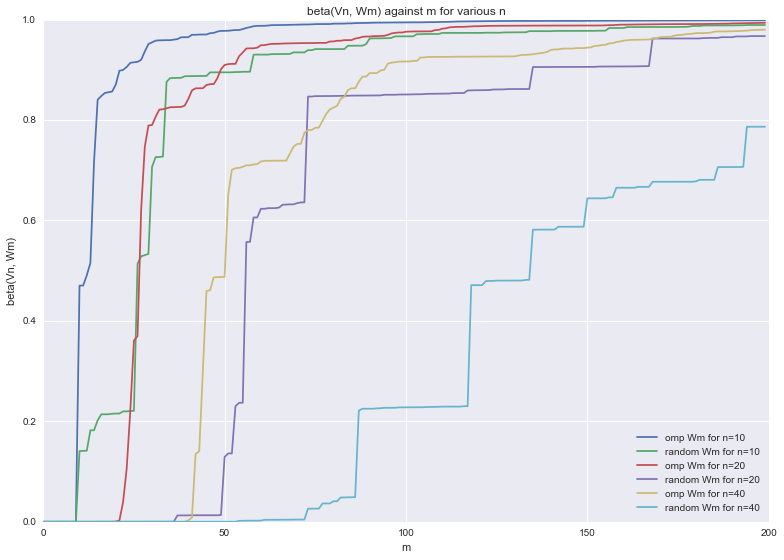

In [4]:
sns.set_palette("deep")
cp = sns.color_palette()

axs = []
fig = plt.figure(figsize=(13, 9))
ax = fig.add_subplot(1, 1, 1, title='beta(Vn, Wm) against m for various n')#, title=r'$\beta(V_n, W_m)$ against $m$ for various $n$')

for i, n in enumerate(ns):
    plt.plot(range(m), bs_omp[i, :], label='omp Wm for n={0}'.format(n))#r'OMP constructed $W_m$, $n={{{0}}}$'.format(n))
    plt.plot(range(m), bs_rand[i, :], label='random Wm for n={0}'.format(n))#r'Random $W_m$, $n={{{0}}}$'.format(n))

ax.set(xlabel='m', ylabel='beta(Vn, Wm)')#r'$m$', ylabel=r'$\beta(V_n, W_m)$')
plt.legend(loc=4)
plt.show()

## Take the case $n=20$, lets inspect the actual evaluation points for the basis $W_m$
If $W_m = \mathrm{span}\{\omega_{x_1},\ldots,\omega_{x_m}\}$, where $\langle \omega_{x_k}, f\rangle = f(x_k)$, then what is our set of $x_k$?

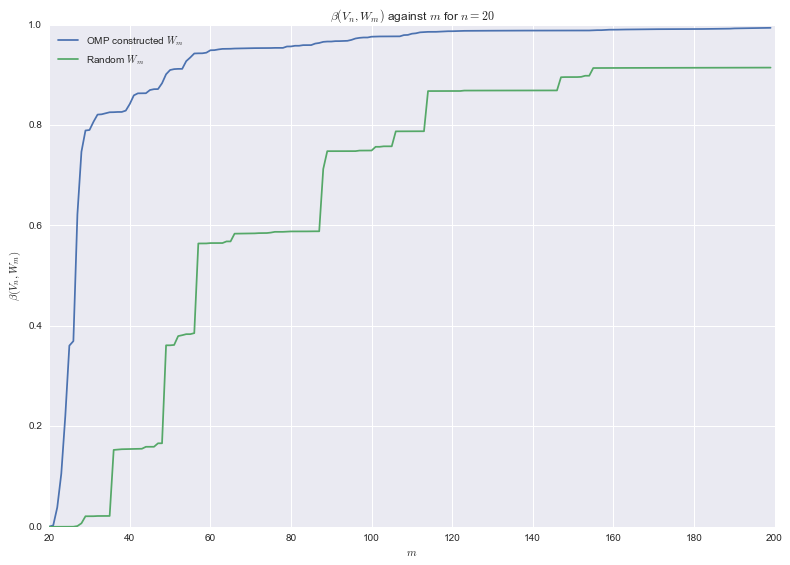

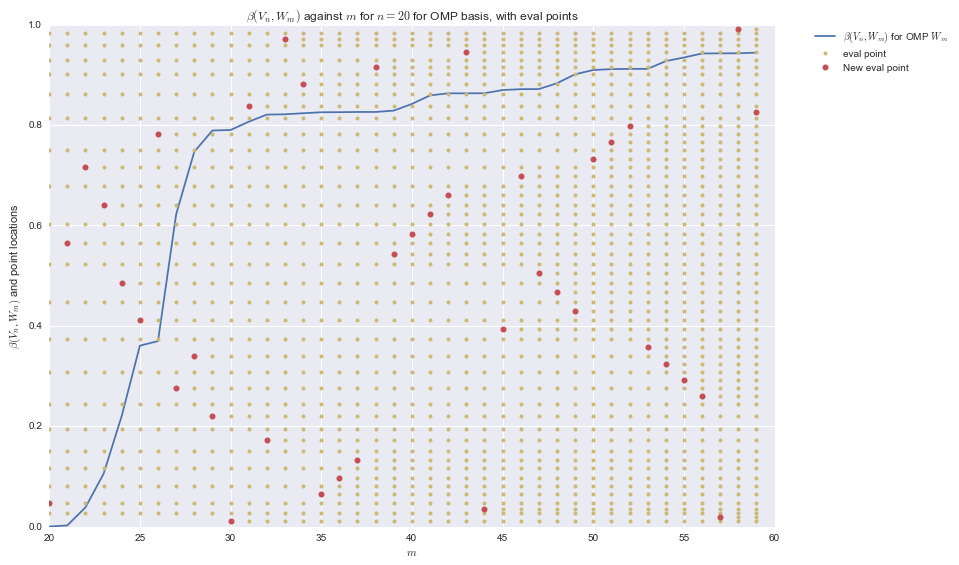

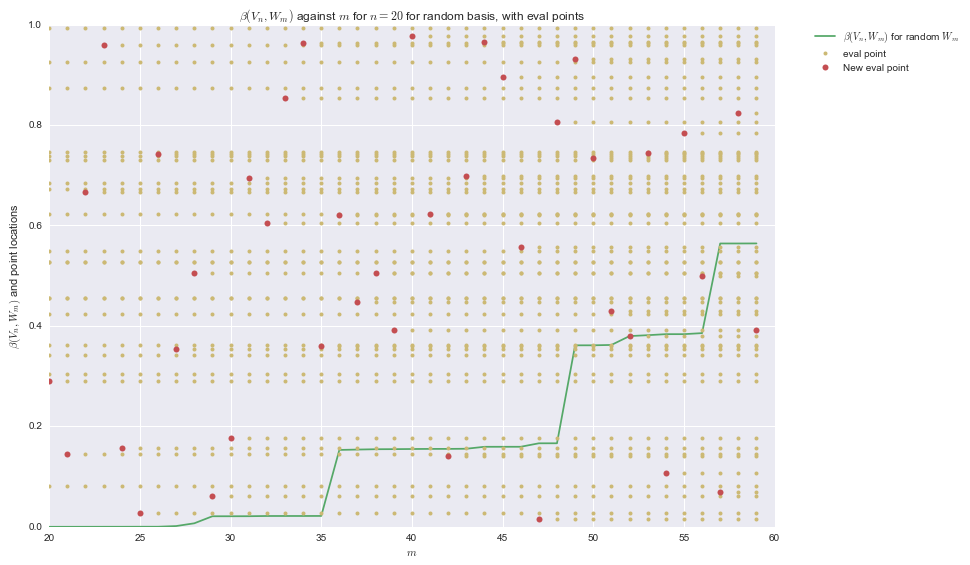

In [36]:
sns.set_palette("deep")
cp = sns.color_palette()

Wm_omp = Wms_omp[1]
Vn = Vn.subspace(slice(0, 20))
b_omp = bs_omp[1,:]
b_rand = bs_rand[1,:]

n=20
m=200

axs = []
fig = plt.figure(figsize=(13, 9))
ax = fig.add_subplot(1, 1, 1, title=r'$\beta(V_n, W_m)$ against $m$ for $n={{{0}}}$'.format(n))

plt.plot(range(n,m), b_omp[n:], label=r'OMP constructed $W_m$')
plt.plot(range(n,m), b_rand[n:], label=r'Random $W_m$')

ax.set(xlabel=r'$m$', ylabel=r'$\beta(V_n, W_m)$')
plt.legend(loc=2)
plt.show()


# Plot the evaluation points in the Wm_rand basis 
# (note that the basis is infact orthonormalised so this isn't *quite* an accurate picture)
Wm_points = [vec.params[0][0] for vec in Wm_omp.vecs]

axs = []
fig = plt.figure(figsize=(13, 9))
ax = fig.add_subplot(1, 1, 1, title=r'$\beta(V_n, W_m)$ against $m$ for $n={{{0}}}$ for OMP basis, with eval points'.format(n))
ax.set(xlabel=r'$m$', ylabel=r'$\beta(V_n, W_m)$ and point locations')
plt.plot(range(n,n+40), b_omp[20:60], color=cp[0], label=r'$\beta(V_n, W_m)$ for OMP $W_m$')

plt.plot(n * np.ones(n-1), Wm_points[:n-1], 'o', color=cp[4], markersize=4, label='eval point')
plt.plot(n, Wm_points[n-1], 'o', color=cp[2], markersize=6, label='New eval point')
for m_plot in range(n, n+40-1):
    plt.plot((m_plot+1) * np.ones(m_plot), Wm_points[:m_plot], 'o', color=cp[4], markersize=4)
    plt.plot(m_plot+1, Wm_points[m_plot], 'o', color=cp[2], markersize=6)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


# Plot the evaluation points in the Wm_rand basis 
# (note that the basis is infact orthonormalised so this isn't *quite* an accurate picture)
Wm_points = [vec.params[0][0] for vec in Wm_rand.vecs]
Wm_o_coeffs = [vec.coeffs[0] for vec in Wm_rand_o.vecs]

axs = []
fig = plt.figure(figsize=(13, 9))
ax = fig.add_subplot(1, 1, 1, title=r'$\beta(V_n, W_m)$ against $m$ for $n={{{0}}}$ for random basis, with eval points'.format(n))
ax.set(xlabel=r'$m$', ylabel=r'$\beta(V_n, W_m)$ and point locations')
plt.plot(range(n,n+40), b_rand[20:60], color=cp[1], label=r'$\beta(V_n, W_m)$ for random $W_m$')

plt.plot(n * np.ones(n-1), Wm_points[:n-1], 'o', color=cp[4], markersize=4, label='eval point')
plt.plot(n, Wm_points[n-1], 'o', color=cp[2], markersize=6, label='New eval point')
for m_plot in range(n, n+40-1):
    plt.plot((m_plot+1) * np.ones(m_plot), Wm_points[:m_plot], 'o', color=cp[4], markersize=4)
    plt.plot(m_plot+1, Wm_points[m_plot], 'o', color=cp[2], markersize=6)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


In [15]:
bs_unif_int = np.zeros((len(ns), m))
Vn = pat.make_sin_basis(ns[-1])

Wms_unif_int = []

for j, n in enumerate(ns):
    for i in range(n, m):
        
        Wm_unif_int = pat.Basis([pat.FuncVector(params=[[x]],coeffs=[[1.0]],funcs=['H1delta']) for x in np.linspace(0.0, 1.0, i, endpoint=False)+0.5/i])
        Wm_unif_int_o = Wm_unif_int.orthonormalise()

        BP_ui = pat.BasisPair(Wm_unif_int_o, Vn.subspace(slice(0,n)))
        FB_ui = BP_ui.make_favorable_basis()
        bs_unif_int[j, i] = FB_ui.beta()

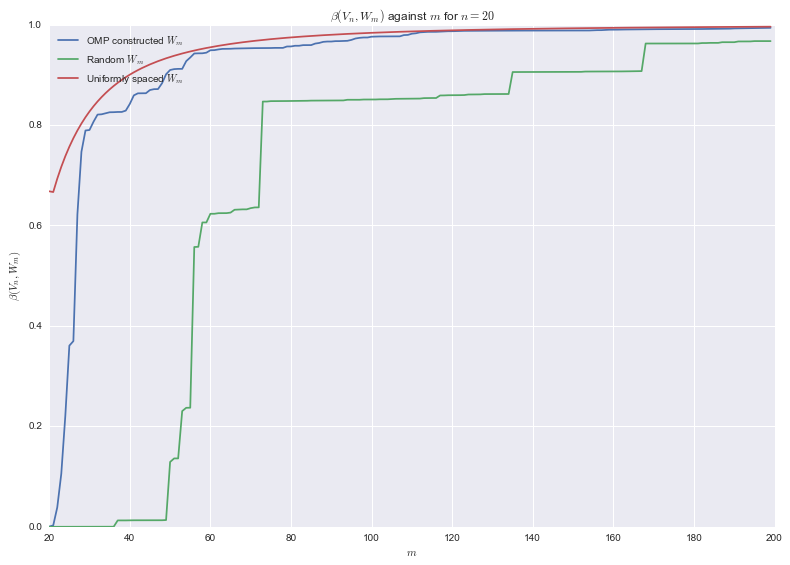

In [16]:
n = ns[1]
Wm_omp = Wms_omp[1]
Vn = Vn.subspace(slice(0, 20))
b_omp = bs_omp[1,:]
b_rand = bs_rand[1,:]
b_ui = bs_unif_int[1,:]

axs = []
fig = plt.figure(figsize=(13, 9))
ax = fig.add_subplot(1, 1, 1, title=r'$\beta(V_n, W_m)$ against $m$ for $n={{{0}}}$'.format(n))

plt.plot(range(n,m), b_omp[n:], label=r'OMP constructed $W_m$')
plt.plot(range(n,m), b_rand[n:], label=r'Random $W_m$')
plt.plot(range(n,m), b_ui[n:], label=r'Uniformly spaced $W_m$')

ax.set(xlabel=r'$m$', ylabel=r'$\beta(V_n, W_m)$')
plt.legend(loc=2)
plt.show()


## Lets look at some bases constructed on the cluster, and examine $m$ vs $n$ for a fixed minimum $\beta(V_n,W_m)$
Here we have used a large dictionary, where $\mathcal{D}$ has $N = 10^6$ elements. Surprisingly we get very very good results: $\beta(V_n, W_m)\to 1$ quite quickly

In [6]:
m=200
ns = [5, 10, 20, 40]#, 100]
bs_unif = np.zeros((len(ns), m))
bs_rand = np.zeros((len(ns), m))
bs_arb = np.zeros((len(ns), m))

gammas = np.arange(0., 1.1, 0.1)
m_gammas_unif = np.zeros((len(ns), len(gammas)))
m_gammas_rand = np.zeros((len(ns), len(gammas)))
m_gammas_arb = np.zeros((len(ns), len(gammas)))

for j, n in enumerate(ns):
    Vn = pat.make_sin_basis(n)
    
    omp_unif_x = np.load('omp_x_unif_{0}_10000.npy'.format(n))
    Wm_omp_unif = pat.Basis(vecs=[omp.Vector([x], [1.0], ['H1delta']) for x in omp_unif_x])
    Wm_omp_unif_o = Wm_omp_unif.orthonormalise()

    omp_rand_x = np.load('omp_x_rand_{0}_10000.npy'.format(n))
    Wm_omp_rand = pat.Basis(vecs=[omp.Vector([x], [1.0], ['H1delta']) for x in omp_rand_x])
    Wm_omp_rand_o = Wm_omp_rand.orthonormalise()

    Wm_arb = pat.make_random_delta_basis(m)
    Wm_arb_o = Wm_arb.orthonormalise()
    
    for i in range(n, m):
        BP_unif = pat.BasisPair(Wm_omp_unif_o.subspace(slice(0,i)), Vn)
        FB_unif = BP_unif.make_favorable_basis()
        bs_unif[j,i] = FB_unif.beta()

        BP_rand = pat.BasisPair(Wm_omp_rand_o.subspace(slice(0,i)), Vn)
        FB_rand = BP_rand.make_favorable_basis()
        bs_rand[j,i] = FB_rand.beta()
    
        BP_arb = pat.BasisPair(Wm_arb_o.subspace(slice(0,i)), Vn)
        FB_arb = BP_arb.make_favorable_basis()
        bs_arb[j,i] = FB_arb.beta()
    
    # Make the pivot data - the minimum m to reach some beta
    for i, gamma in enumerate(gammas):
        
        m_gammas_unif[j, i] = np.searchsorted(bs_unif[j,:], gamma)
        m_gammas_rand[j, i] = np.searchsorted(bs_rand[j,:], gamma)
        m_gammas_arb[j, i] = np.searchsorted(bs_arb[j,:], gamma)
        

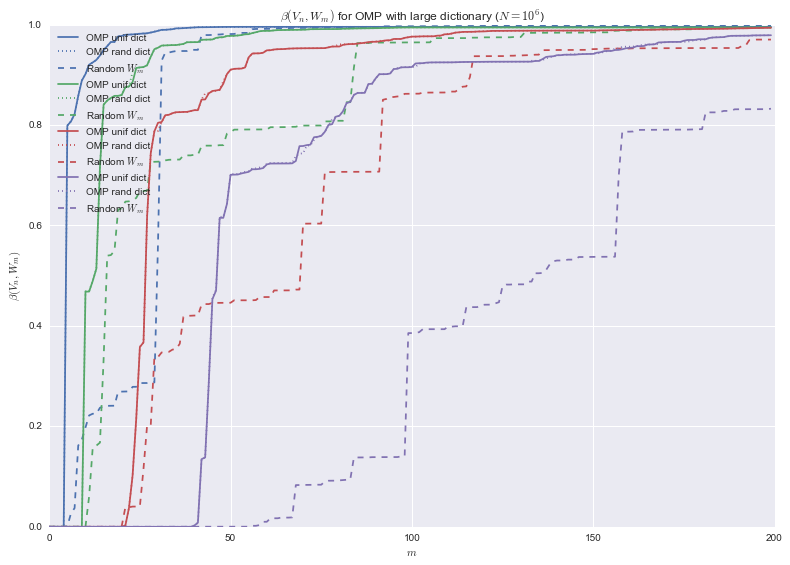

"THIS PLOT BELOW IS INTERESTING BUT CONFUSING: COMMENTED OUT FOR NOW\naxs = []\nfig = plt.figure(figsize=(13, 9))\nax = fig.add_subplot(1, 1, 1, title=r'Minimum $m$ to attain $\\gamma$'.format(n))\n\nfor i, n in enumerate(ns):\n    \n    plt.plot(gammas, m_gammas_unif[i, :], label=r'OMP unif dict', color=cp[i])\n    #plt.plot(gammas, m_gammas_rand[i, :], ':', label=r'OMP rand dict', color=cp[i])\n    plt.plot(gammas, m_gammas_arb[i, :], '--', label=r'Random $W_m$', color=cp[i])\n    \nax.set(xlabel=r'$\\gamma$', ylabel=r'$\\mathrm{argmin}\\{m : \x08eta(V_n, W_m) > \\gamma \\}$')\nplt.legend(loc=2)\nplt.show()\n"

In [7]:
sns.set_palette("deep")
cp = sns.color_palette()

axs = []
fig = plt.figure(figsize=(13, 9))
ax = fig.add_subplot(1, 1, 1, title=r'$\beta(V_n, W_m)$ for OMP with large dictionary ($N=10^6$)')

for i, n in enumerate(ns):
    
    plt.plot(range(m), bs_unif[i, :], label=r'OMP unif dict', color=cp[i])
    plt.plot(range(m), bs_rand[i, :], ':', label=r'OMP rand dict', color=cp[i])
    plt.plot(range(m), bs_arb[i, :], '--', label=r'Random $W_m$', color=cp[i])
    
ax.set(xlabel=r'$m$', ylabel=r'$\beta(V_n, W_m)$')
plt.legend(loc=2)
plt.show()

"""THIS PLOT BELOW IS INTERESTING BUT CONFUSING: COMMENTED OUT FOR NOW
axs = []
fig = plt.figure(figsize=(13, 9))
ax = fig.add_subplot(1, 1, 1, title=r'Minimum $m$ to attain $\gamma$'.format(n))

for i, n in enumerate(ns):
    
    plt.plot(gammas, m_gammas_unif[i, :], label=r'OMP unif dict', color=cp[i])
    #plt.plot(gammas, m_gammas_rand[i, :], ':', label=r'OMP rand dict', color=cp[i])
    plt.plot(gammas, m_gammas_arb[i, :], '--', label=r'Random $W_m$', color=cp[i])
    
ax.set(xlabel=r'$\gamma$', ylabel=r'$\mathrm{argmin}\{m : \beta(V_n, W_m) > \gamma \}$')
plt.legend(loc=2)
plt.show()
"""

## Ok, lets look quickly at the points generated with the large dictionary, versus the points generated above with the small dictionary
We actually see that the results for $\beta(V_n,W_m)$ are almost identical for the two dictionaries, which is encouraging.

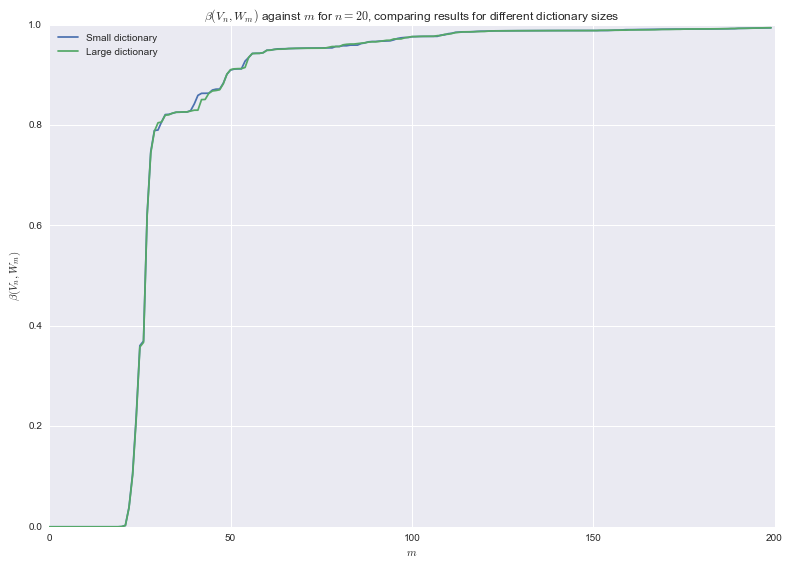

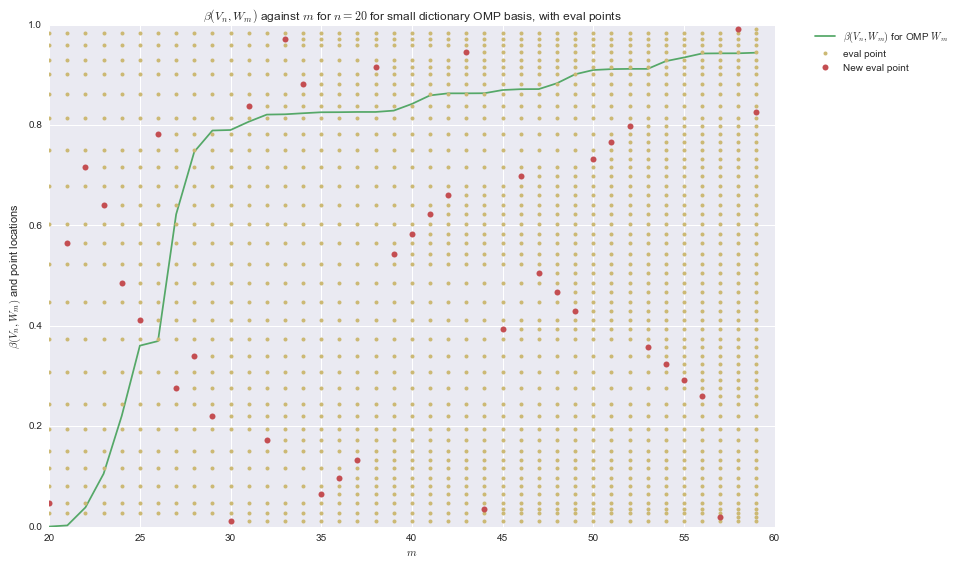

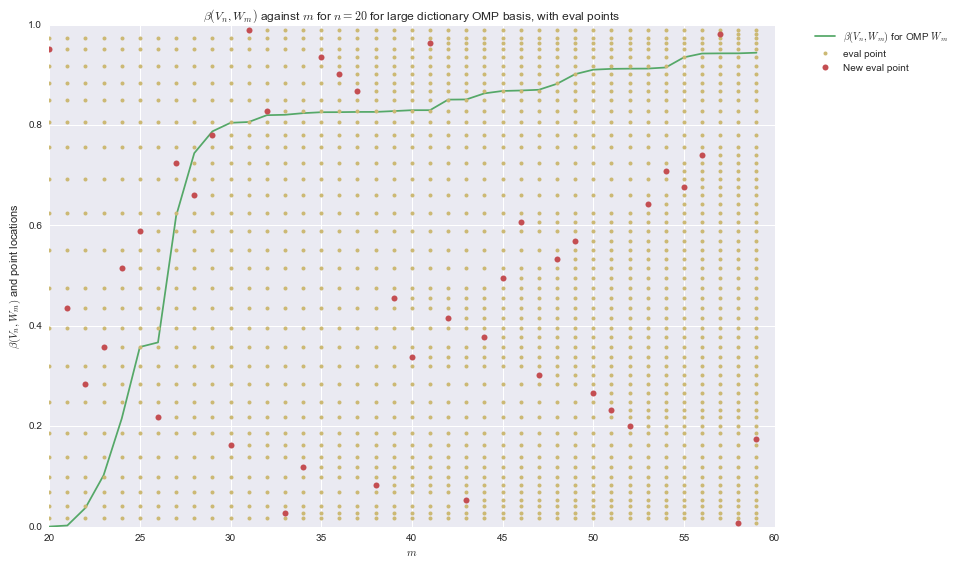

[  0.00000000e+00   4.43378789e-04   2.58825228e-03   3.77524256e-02
   1.02652977e-01   2.15543270e-01   3.58037177e-01   3.67162630e-01
   6.19193437e-01   7.44092977e-01   7.87441003e-01]


In [14]:
sns.set_palette("deep")
cp = sns.color_palette()

Wm_omp = Wms_omp[1]
Vn = Vn.subspace(slice(0, 20))
b_omp = bs_omp[1,:]
n=20

axs = []
fig = plt.figure(figsize=(13, 9))
ax = fig.add_subplot(1, 1, 1, title=r'$\beta(V_n, W_m)$ against $m$ for $n={{{0}}}$, comparing results for different dictionary sizes'.format(n))

plt.plot(range(m), b_omp[:], label=r'Small dictionary')
plt.plot(range(m), bs_unif[2, :], label=r'Large dictionary')

ax.set(xlabel=r'$m$', ylabel=r'$\beta(V_n, W_m)$')
plt.legend(loc=2)
plt.show()

# Plot the evaluation points in the Wm_omp basis - generated from a small dictionary
Wm_points = [vec.params[0][0] for vec in Wm_omp.vecs]

axs = []
fig = plt.figure(figsize=(13, 9))
ax = fig.add_subplot(1, 1, 1, title=r'$\beta(V_n, W_m)$ against $m$ for $n={{{0}}}$ for small dictionary OMP basis, with eval points'.format(n))
ax.set(xlabel=r'$m$', ylabel=r'$\beta(V_n, W_m)$ and point locations')
plt.plot(range(n,n+40), b_omp[20:60], color=cp[1], label=r'$\beta(V_n, W_m)$ for OMP $W_m$')

plt.plot(n * np.ones(n-1), Wm_points[:n-1], 'o', color=cp[4], markersize=4, label='eval point')
plt.plot(n, Wm_points[n-1], 'o', color=cp[2], markersize=6, label='New eval point')
for m_plot in range(n, n+40-1):
    plt.plot((m_plot+1) * np.ones(m_plot), Wm_points[:m_plot], 'o', color=cp[4], markersize=4)
    plt.plot(m_plot+1, Wm_points[m_plot], 'o', color=cp[2], markersize=6)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


# Now for the Wm_omp_unif basis - generated from a large dictionary
omp_unif_x = np.load('omp_x_unif_{0}_10000.npy'.format(n))
Wm_omp_unif = pat.Basis(vecs=[omp.Vector([x], [1.0], ['H1delta']) for x in omp_unif_x])

Wm_points = [vec.params[0][0] for vec in Wm_omp_unif.vecs]

axs = []
fig = plt.figure(figsize=(13, 9))
ax = fig.add_subplot(1, 1, 1, title=r'$\beta(V_n, W_m)$ against $m$ for $n={{{0}}}$ for large dictionary OMP basis, with eval points'.format(n))
ax.set(xlabel=r'$m$', ylabel=r'$\beta(V_n, W_m)$ and point locations')
plt.plot(range(n,n+40), bs_unif[2, 20:60], color=cp[1], label=r'$\beta(V_n, W_m)$ for OMP $W_m$')

plt.plot(n * np.ones(n-1), Wm_points[:n-1], 'o', color=cp[4], markersize=4, label='eval point')
plt.plot(n, Wm_points[n-1], 'o', color=cp[2], markersize=6, label='New eval point')
for m_plot in range(n, n+40-1):
    plt.plot((m_plot+1) * np.ones(m_plot), Wm_points[:m_plot], 'o', color=cp[4], markersize=4)
    plt.plot(m_plot+1, Wm_points[m_plot], 'o', color=cp[2], markersize=6)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

print(bs_unif[2, 19:30])